In [9]:
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymutspec.annotation import rev_comp
from pymutspec.constants import possible_sbs192
from pymutspec.draw import plot_mutspec192
import SigProfilerAssignment
from SigProfilerAssignment import Analyzer as Analyze

from utils import (
    sbs2effect, collapse_sbs192, complete_sbs_columns, 
    read_human_triplet_counts,
)

sns.set_style()

ModuleNotFoundError: No module named 'SigProfilerAssignment'

In [ ]:
# version of SigProfilerAssignment
SigProfilerAssignment.__version__

'0.1.6'

In [2]:
possible_sbs6 = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
possible_sbs96 = [x for x in possible_sbs192 if x[2:5] in possible_sbs6]
print(possible_sbs96)

['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G'

In [6]:
# Load and prepare data
species_spectra = pd.read_csv('../1data_derivation/dataset/MutSpecVertebrates192.csv.gz')
species_spectra = species_spectra[species_spectra.Gene == 'Cytb']
species_spectra['Mut'] = species_spectra['Mut'].apply(rev_comp) # to H-strand notation

print(species_spectra.Species.nunique(), 'species')
species_spectra.head()

1697 species


,Gene,Class,Species,Mut,Observed,Expected,MutSpec
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0


In [8]:
# check most popular sbs - we see C>T, therefore we are using H-strand 
species_spectra.groupby('Mut').MutSpec.mean().sort_values()

Mut
C[T>G]T    0.000000
A[T>A]T    0.000000
A[T>G]T    0.000000
C[A>C]T    0.000000
C[A>T]T    0.000000
             ...   
A[C>T]T    0.028516
A[C>T]A    0.029996
G[C>T]C    0.031454
A[C>T]C    0.039361
C[C>T]C    0.043280
Name: MutSpec, Length: 192, dtype: float64

## Prepare input files

### Prepare species dataset

1. only transitions on light 
2. only C>T (light)
3. only A>G (light)

In [11]:
species_ct_raw = species_spectra[species_spectra.sbs12h == "G>A"]
species_ct_raw['sbs96'] = species_ct_raw.sbs192h.apply(rev_comp)

species_ag_raw = species_spectra[species_spectra.sbs12h == "T>C"]
species_ag_raw['sbs96'] = species_ag_raw.sbs192h

species_transitions_raw = pd.concat([species_ct_raw, species_ag_raw], ignore_index=True)

species_ct = complete_sbs_columns(
    species_ct_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack(), 96)
species_ag = complete_sbs_columns(
    species_ag_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack(), 96)
species_transitions = complete_sbs_columns(
    species_transitions_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack(), 96)

# assert (species_transitions.columns.values == cosmic_filtered.columns.values).all()
# assert (species_ct.columns.values == cosmic_filtered.columns.values).all()
# assert (species_ag.columns.values == cosmic_filtered.columns.values).all()

species_transitions.head(5).round(4)

AttributeError: 'DataFrame' object has no attribute 'sbs12h'

In [10]:
species_transitions.columns.name = "MutationType"
species_transitions = species_transitions[sorted(possible_sbs96)]
cls_transitions = species_transitions.mean(level=0).T
cls_transitions

NameError: name 'species_transitions' is not defined

In [28]:
import json
from pymutspec.constants import possible_codons

def read_human_triplet_counts(include_lower_nucls=False):
    with open("./data/triplet_counts_GRCh37.json") as fin:
        _human_counts_raw = json.load(fin)
        if include_lower_nucls:
            human_counts = defaultdict(int)
            for triplet, n in _human_counts_raw.items():
                human_counts[triplet.upper()] += n
            human_counts = dict(human_counts)        
        else:
            _human_counts_raw = {x: _human_counts_raw[x] for x in possible_codons} # without aAa, tAA, etc.
            human_counts = defaultdict(int)
            for triplet, n in _human_counts_raw.items():
                human_counts[triplet.upper()] += n
            human_counts = dict(human_counts)
        return human_counts

human_counts = read_human_triplet_counts()
human_counts_wl = read_human_triplet_counts(True)

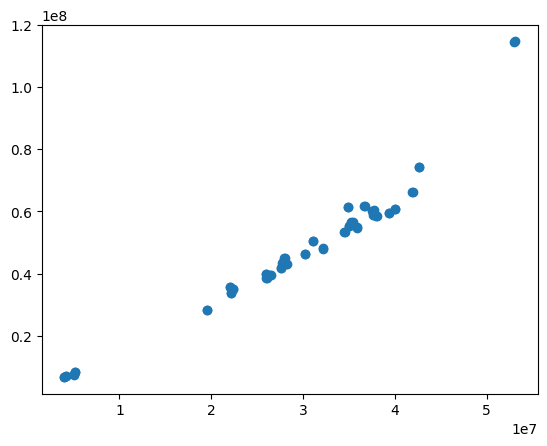

In [41]:
plt.scatter(pd.Series(human_counts).sort_index().values, pd.Series(human_counts_wl).sort_index().values)

In [35]:
pd.Series(human_counts).rename('wo lower')

AAA    52955787
AAC    27685307
AAG    39328248
AAT    42582891
ACA    37558475
         ...   
TGT    37690444
TTA    36702017
TTC    37682795
TTG    35419535
TTT    53104035
Name: wo lower, Length: 64, dtype: int64

In [36]:
pd.Series(human_counts_wl).rename('with lower')

TAA     61780796
AAC     43438625
ACC     34902100
CCC     39661785
CCT     53384677
         ...    
TTA     61863454
TAT     61327462
ATA     61281300
ATT     74229882
TTT    114683164
Name: with lower, Length: 64, dtype: int64

In [26]:
len({x: human_counts[x] for x in possible_codons})

64

In [27]:
pd.Series(human_counts).sort_values()

CGA     3997304
TCG     4008355
CGC     4159750
GCG     4165712
ACG     5065207
         ...   
TCT    41940160
AAT    42582891
ATT    42641599
AAA    52955787
TTT    53104035
Length: 64, dtype: int64

In [54]:
# forvard and rev-comp triplets (pairs) freqs are almost equal
d = defaultdict(dict)
for triplet, n in human_counts.items():
    if triplet[1] in "CT":
        # print(triplet, n)
        d[triplet]["cosmic"] = n
    else:
        d[rev_comp(triplet)]["other"] = n

d = pd.DataFrame(d).T
d["diff"] = d.cosmic - d.other
d["diff%"] = d["diff"] / d['cosmic']
d

,other,cosmic,diff,diff%
TTT,52955787,53104035,148248,0.002792
GTT,27685307,27789456,104149,0.003748
CTT,39328248,39390888,62640,0.001590
ATT,42582891,42641599,58708,0.001377
ACA,37690444,37558475,-131969,-0.003514
ACC,22396794,22362749,-34045,-0.001522
ACG,5075138,5065207,-9931,-0.001961
ACT,32216082,32173783,-42299,-0.001315
TCT,41895792,41940160,44368,0.001058
GCT,27570880,27581893,11013,0.000399


So, need to use triplets with C & T in 2nd position

In [55]:
multiplier = cls_transitions.index.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
multiplier

MutationType
A[C>A]A    37558475
A[C>A]C    22362749
A[C>A]G     5065207
A[C>A]T    32173783
A[C>G]A    37558475
             ...   
T[T>C]T    53104035
T[T>G]A    36702017
T[T>G]C    37682795
T[T>G]G    35419535
T[T>G]T    53104035
Name: MutationType, Length: 96, dtype: int64

### Many variants:

- **low ts** only
- **low ts** + mean tv [(h + l) / 2]
- **high ts** only
- **high ts** + mean tv [(h + l) / 2]
- **high - low** ts only
- **high - low** ts + mean tv [(h + l) / 2]

In [51]:
def save_wide_cls_spectra(df: pd.DataFrame, filename=None, scale_coef=6.6e-5):
    assert df.shape[1] == 96
    df.columns.name = "MutationType"
    multiplier = df.columns.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
    rescaled = (df * multiplier * scale_coef).T
    rescaled = rescaled.round().astype(int)
    if filename is not None:
        rescaled.sort_index().to_csv(filename, sep="\t")
    return rescaled

In [50]:
species_spectra_wide = complete_sbs_columns(
    species_spectra.groupby(["Class", "Species", "Mut"]).MutSpec.sum().unstack(), 192)
cls_spectra_wide = species_spectra_wide.mean(level=0)
cls_spectra_wide.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000066,0.001479,0.000500,0.0,0.000865,0.002439,0.000998,0.0,0.000387,0.000729,...,0.001011,0.0,0.001081,0.001138,0.002074,0.0,0.000458,0.000397,0.000828,0.0
Amphibia,0.000000,0.000273,0.000506,0.0,0.001441,0.004229,0.001683,0.0,0.000102,0.000000,...,0.000734,0.0,0.000593,0.000470,0.001442,0.0,0.000355,0.000000,0.001295,0.0
Aves,0.000000,0.000000,0.000051,0.0,0.000048,0.000000,0.000088,0.0,0.000000,0.001011,...,0.000374,0.0,0.000633,0.001844,0.001183,0.0,0.000364,0.000000,0.000183,0.0
Lepidosauria,0.000023,0.001169,0.000357,0.0,0.001099,0.002600,0.001345,0.0,0.000801,0.000801,...,0.000593,0.0,0.000765,0.000169,0.001713,0.0,0.000393,0.000233,0.000728,0.0
Mammalia,0.000000,0.000783,0.000064,0.0,0.001615,0.001756,0.000464,0.0,0.000140,0.000724,...,0.000524,0.0,0.000615,0.000608,0.000894,0.0,0.000375,0.000394,0.000538,0.0


**Only Ts's**

In [58]:
sbs_low_ts = ["G>A", "T>C"]
low_ts_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_low_ts]], 192), 96)
# save_wide_cls_spectra(low_ts_only, "../data/decomp/SigProfilerAssignment/input/low_ts_only.txt")
low_ts_only

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
sbs_high_ts = ["C>T", "A>G"]
high_ts_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_high_ts]], 192), 96)
high_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
high_minus_low_ts_only = high_ts_only - low_ts_only
high_minus_low_ts_only[high_minus_low_ts_only < 0] = 0
high_minus_low_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Ts's + Tv's**

In [61]:
sbs_tv = ['A>C', 'A>T', 'C>A', 'C>G', 'G>C', 'G>T', 'T>A', 'T>G']
tv_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_tv]], 192), 96) / 2
tv_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [63]:
tv_only[['C[C>T]C']]

Mut,C[C>T]C
Class,
Actinopteri,0.0
Amphibia,0.0
Aves,0.0
Lepidosauria,0.0
Mammalia,0.0


In [62]:
low_ts_with_tv = tv_only + low_ts_only
# save_wide_cls_spectra(low_ts_with_tv, "../data/decomp/low_ts_with_tv.txt")
low_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [64]:
high_ts_with_tv = tv_only + high_ts_only
high_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [65]:
high_minus_low_ts_with_tv = tv_only + high_minus_low_ts_only
high_minus_low_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


Concatenate pairwise all 6 variants

In [66]:
d = []
for x, _lbl in zip(
        [low_ts_only, low_ts_with_tv],
        ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, 
    "../data/decomp/SigProfilerAssignment/input/low_Ts_samples.txt"
)


d = []
for x, _lbl in zip(
    [high_ts_only, high_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, 
    "../data/decomp/SigProfilerAssignment/input/high_Ts_samples.txt"
)


d = []
for x, _lbl in zip(
    [high_minus_low_ts_only, high_minus_low_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, 
    "../data/decomp/SigProfilerAssignment/input/high_minus_low_Ts_samples.txt"
)

,Actinopteri__Ts only,Amphibia__Ts only,Aves__Ts only,Lepidosauria__Ts only,Mammalia__Ts only,Actinopteri__Ts & Tv,Amphibia__Ts & Tv,Aves__Ts & Tv,Lepidosauria__Ts & Tv,Mammalia__Ts & Tv
MutationType,,,,,,,,,,
A[C>A]A,0,0,0,0,0,0,0,0,0,0
A[C>A]C,0,0,0,0,0,1,0,0,2,1
A[C>A]G,0,0,0,0,0,0,0,0,0,0
A[C>A]T,0,0,0,0,0,0,0,0,0,0
C[C>A]A,0,0,0,0,0,3,3,2,8,3
...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,0,0,0,0,0,1,0,0,1,1
T[T>G]A,0,0,0,0,0,1,0,2,1,1
T[T>G]C,0,0,0,0,0,1,0,0,1,1


In [171]:
save_wide_cls_spectra(collapse_sbs192(cls_spectra_wide, 96), 
                      "../data/decomp/simple_96_saples.txt")

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
MutationType,,,,,
A[C>A]A,0,0,0,0,1
A[C>A]C,1,0,0,4,2
A[C>A]G,0,0,0,0,0
A[C>A]T,0,0,0,0,0
C[C>A]A,6,7,4,17,6
...,...,...,...,...,...
G[T>G]T,3,1,0,2,1
T[T>G]A,2,1,4,1,1
T[T>G]C,2,0,0,3,1


## Run SigProfilerAssignment

In [217]:
from SigProfilerAssignment import Analyzer as Analyze

samples_pattern = "../data/decomp/SigProfilerAssignment/input/{}_samples.txt"
output_pattern = "../data/decomp/SigProfilerAssignment/output/{}/"

exclude_signature_subgroups = [
    'Artifact_signatures',
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'Lymphoid_signatures',
    'Colibactin_signatures',
    'AA_signatures',
]

for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]:
    samples = samples_pattern.format(label)
    output  = output_pattern.format(label)
    Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                    cosmic_version=3.3, exome=False,
                    nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                    exclude_signature_subgroups=exclude_signature_subgroups, 
                    export_probabilities=False, make_plots=True,
                    sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 10/10 [100%] in 1.4s (7.09/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 3.0s (3.32/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 1.7s (5

In [218]:
# make Solution_Stats with assignment quality
d = pd.concat([pd.read_csv(f"../data/decomp/SigProfilerAssignment/output/{label}/"
        "Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')\
            .assign(Run=label).set_index(['Run', 'Sample Names']) \
            for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]])
d.to_csv('../data/decomp/SigProfilerAssignment/output/Solution_Stats.txt', sep='\t')
d.head(2)

Total Mutations  Cosine Similarity  L1 Norm  \
Run    Sample Names                                                        
low_Ts Actinopteri__Ts only              496              0.938  202.460   
       Amphibia__Ts only                 507              0.916  233.596   

                            L1_Norm_%  L2 Norm L2_Norm_%  KL Divergence  \
Run    Sample Names                                                       
low_Ts Actinopteri__Ts only   40.819%   34.667   34.955%        0.17688   
       Amphibia__Ts only      46.074%   43.321   40.611%        0.22380   

                             Correlation  
Run    Sample Names                       
low_Ts Actinopteri__Ts only        0.915  
       Amphibia__Ts only           0.889

### Make beautiful images and add them to single panel
in the scpipt [plotActivity.py](./plotActivity.py)

In [14]:
import pandas as pd

# merge tables to 'total' one
data = []
index_odr = [
 'Actinopteri__Ts only',
 'Amphibia__Ts only',
 'Aves__Ts only',
 'Lepidosauria__Ts only',
 'Mammalia__Ts only',
 'Actinopteri__Ts & Tv',
 'Amphibia__Ts & Tv',
 'Aves__Ts & Tv',
 'Lepidosauria__Ts & Tv',
 'Mammalia__Ts & Tv',
 ]

for label in ["high_Ts", "low_Ts", "high_minus_low_Ts"]:
    d = pd.read_csv(f'../data/decomp/SigProfilerAssignment/output/{label}/'
                'Assignment_Solution/Activities/Assignment_Solution_Activities.txt', 
                sep='\t', index_col=0).loc[index_odr]
    
    if label == 'low_Ts':
        label = 'low-'
    elif label == 'high_Ts':
        label = 'high-'
    elif label == 'high_minus_low_Ts':
        label = 'diff-'
    
    d.index = label + d.index.str.replace(' only', '')
    data.append(d)

df_full = pd.concat(data)
df_ts_only = df_full.loc[~df_full.index.str.contains('Tv')]
df_ts_only.index = df_ts_only.index.str.replace('__Ts', '')


path_to_total_acivities = '../data/decomp/SigProfilerAssignment/output/Assignment_Solution_Activities.txt'
df_full.to_csv(path_to_total_acivities, sep='\t')
df_ts_only.to_csv(path_to_total_acivities.replace('.txt', '_Ts.txt'), sep='\t')
df_full.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS39,SBS40,SBS41,SBS42,SBS44,SBS89,SBS91,SBS92,SBS93,SBS94
Samples,,,,,,,,,,,,,,,,,,,,,
high-Actinopteri__Ts,3,0,0,0,208,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Amphibia__Ts,0,57,0,0,102,0,0,0,0,0,...,0,0,0,0,193,0,0,0,0,0
high-Aves__Ts,0,0,0,0,342,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Lepidosauria__Ts,3,0,0,0,203,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Mammalia__Ts,0,0,0,0,189,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# total
from plotActivity import plotActivity

custom_colors = ['lightgray', '#63d69e', 'lightgray', '#fcde97', '#fcde97', 
                 'tab:pink', 'lightgray', 'lightgray', 'tab:purple']
outpath = "../data/decomp/SigProfilerAssignment/output/total.pdf"
plotActivity(
    path_to_total_acivities, outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=2,
    # rename=True,
)

['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']


In [21]:
# only Ts
from plotActivity import plotActivity

custom_colors = ['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 
                 'tab:pink', 'tab:olive', 'tab:orange', 'tab:purple']
outpath = "../data/decomp/SigProfilerAssignment/output/only_Ts.pdf"
plotActivity(
    path_to_total_acivities.replace('.txt', '_Ts.txt'), 
    outpath, 
    bin_size=50, 
    custom_colors=custom_colors,
    delimiter_step=5, delimiter_size=2,
    rename=True, figure_width=4,
)

Colors replaced
['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 'tab:pink', 'tab:olive', 'tab:orange', 'tab:purple']


## Priors for mSigAct

In [2]:
import pandas as pd
df = pd.read_csv('../data/decomp/SigProfilerAssignment/output/Assignment_Solution_Activities.txt', sep='\t', index_col=0)
df.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS39,SBS40,SBS41,SBS42,SBS44,SBS89,SBS91,SBS92,SBS93,SBS94
Samples,,,,,,,,,,,,,,,,,,,,,
low-Actinopteri__Ts,2,26,0,0,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Actinopteri__Ts & Tv,0,29,0,0,171,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Amphibia__Ts,2,34,0,0,71,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Amphibia__Ts & Tv,0,37,0,0,194,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Aves__Ts,6,0,0,0,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
sbs_priors = df.sum(axis=0)
sbs_priors = (sbs_priors[sbs_priors > 0] / sbs_priors.sum()).round(2)
sbs_priors = sbs_priors[sbs_priors >= 0.01] # frequent then 1%
sbs_priors.sort_values()

SBS2     0.01
SBS26    0.02
SBS19    0.03
SBS23    0.03
SBS44    0.03
SBS5     0.23
SBS12    0.31
SBS30    0.35
dtype: float64

In [ ]:
#legacy
sbs_priors = df.sum(axis=0)
sbs_priors = (sbs_priors[sbs_priors > 0] / sbs_priors.sum()).round(2)
sbs_priors = sbs_priors[sbs_priors >= 0.01] # frequent then 1%
sbs_priors.sort_values()

SBS2     0.01
SBS23    0.03
SBS44    0.06
SBS5     0.18
SBS30    0.33
SBS12    0.38
dtype: float64

## Plot btacked barplots for mSigAct

In [11]:
# total
import pandas as pd
from plotActivity import plotActivity

custom_colors = [
    '#acf2d0', '#63d69e', '#f8b6b3', '#c4abc4', '#f2aeae', '#d9f7b0', 
    '#faf1dc', '#fcebc2', '#fae4af', '#fae1a5', '#fcde97', '#fad682', 
    'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown', 
    'tab:red', 'tab:green', 'tab:cyan', 'deeppink', 'lightgray', 'blueviolet', 
    'chocolate', 'darkgreen', 'dodgerblue', 'gray', 'salmon']


inpath  = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities.txt"
outpath = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities.pdf"

df = pd.read_csv(inpath, sep='\t')
print(df.shape)
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['WithTv'] = df.Samples.str.contains('Tv')
df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
df = df.sort_values(['Set', 'WithTv', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples').astype(int).drop('WithTv', 1)
# drop signatures with low fraction (< 0.5%)
df = df.loc[:, (df.T / df.sum(1)).T.mean() >= 0.005]
print(df.shape)
df.to_csv(inpath+'.sorted', sep='\t')

plotActivity(
    inpath+'.sorted', 
    outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=3,
    # rename=True,
)

(30, 29)
(30, 13)
['#f8b6b3', '#c4abc4', '#faf1dc', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown', 'tab:red', 'tab:green', 'tab:cyan']


/tmp/ipykernel_24810/477448024.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
/tmp/ipykernel_24810/477448024.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index('Samples').astype(int).drop('WithTv', 1)


In [23]:
# only Ts
import pandas as pd
from plotActivity import plotActivity

inpath  = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities.txt"
outpath = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities_Ts.pdf"

df = pd.read_csv(inpath, sep='\t')
print(df.shape)
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['WithTv'] = df.Samples.str.contains('Tv')
df['Samples'] = df['Samples'].str.replace('__Ts.only', '').str.replace('_', '-')
df = df[~df['Samples'].str.contains('\.\.\.')]
df = df.sort_values(['Set', 'WithTv', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples').astype(int).drop('WithTv', 1)
# drop signatures with low fraction (< 0.5%)
df = df.loc[:, (df.T / df.sum(1)).T.mean() >= 0.005]
print(df.shape)
df.to_csv(inpath+'.sorted.ts', sep='\t')

plotActivity(
    inpath+'.sorted.ts', 
    outpath, 
    bin_size=50, 
    scale=True,
    # custom_colors=custom_colors,
    delimiter_step=5, delimiter_size=2,
    rename=True, figure_width=4,
)

(30, 29)
(15, 7)
['#f8b6b3', '#faf1dc', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple']


/tmp/ipykernel_24810/885822662.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Samples'] = df['Samples'].str.replace('__Ts.only', '').str.replace('_', '-')
/tmp/ipykernel_24810/885822662.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index('Samples').astype(int).drop('WithTv', 1)


### When using some priors

In [ ]:
from plotActivity import plotActivity

custom_colors = ['#63d69e', '#fad682', '#fad682', 'tab:purple', 
                 'tab:pink', 'tab:orange', 'lightgray']

inpath  = "../data/decomp/mSigAct/output/custom_prop_Activities.txt"
outpath = "../data/decomp/mSigAct/output/custom_prop_Activities.pdf"

df = pd.read_csv(inpath, sep='\t')
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
df = df.sort_values(['Set', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples', append=True).astype(int).reset_index(1)
df.to_csv(inpath+'.sorted', index=False, sep='\t')

plotActivity(
    inpath+'.sorted', 
    outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=3,
    # rename=True,
)

['#63d69e', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']


In [ ]:
from plotActivity import plotActivity

custom_colors = ['#63d69e', '#fad682', '#fad682', 'tab:purple', 
                 'tab:pink', 'tab:orange', 'lightgray']

inpath  = "../data/decomp/mSigAct/output/custom_from1_Activities.txt"
outpath = "../data/decomp/mSigAct/output/custom_from1_Activities.pdf"

df = pd.read_csv(inpath, sep='\t')
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
df = df.sort_values(['Set', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples', append=True).astype(int).reset_index(1)
df.to_csv(inpath+'.sorted', index=False, sep='\t')

plotActivity(
    inpath+'.sorted', 
    outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=3,
    # rename=True,
)

['#f8b6b3', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown']


## Check input spectra

In [4]:
low = pd.read_csv('../data/decomp/SigProfilerAssignment/input/low_Ts_samples.txt', sep='\t', index_col=0)
high = pd.read_csv('../data/decomp/SigProfilerAssignment/input/high_Ts_samples.txt', sep='\t', index_col=0)
hml = pd.read_csv('../data/decomp/SigProfilerAssignment/input/high_minus_low_Ts_samples.txt', sep='\t', index_col=0)

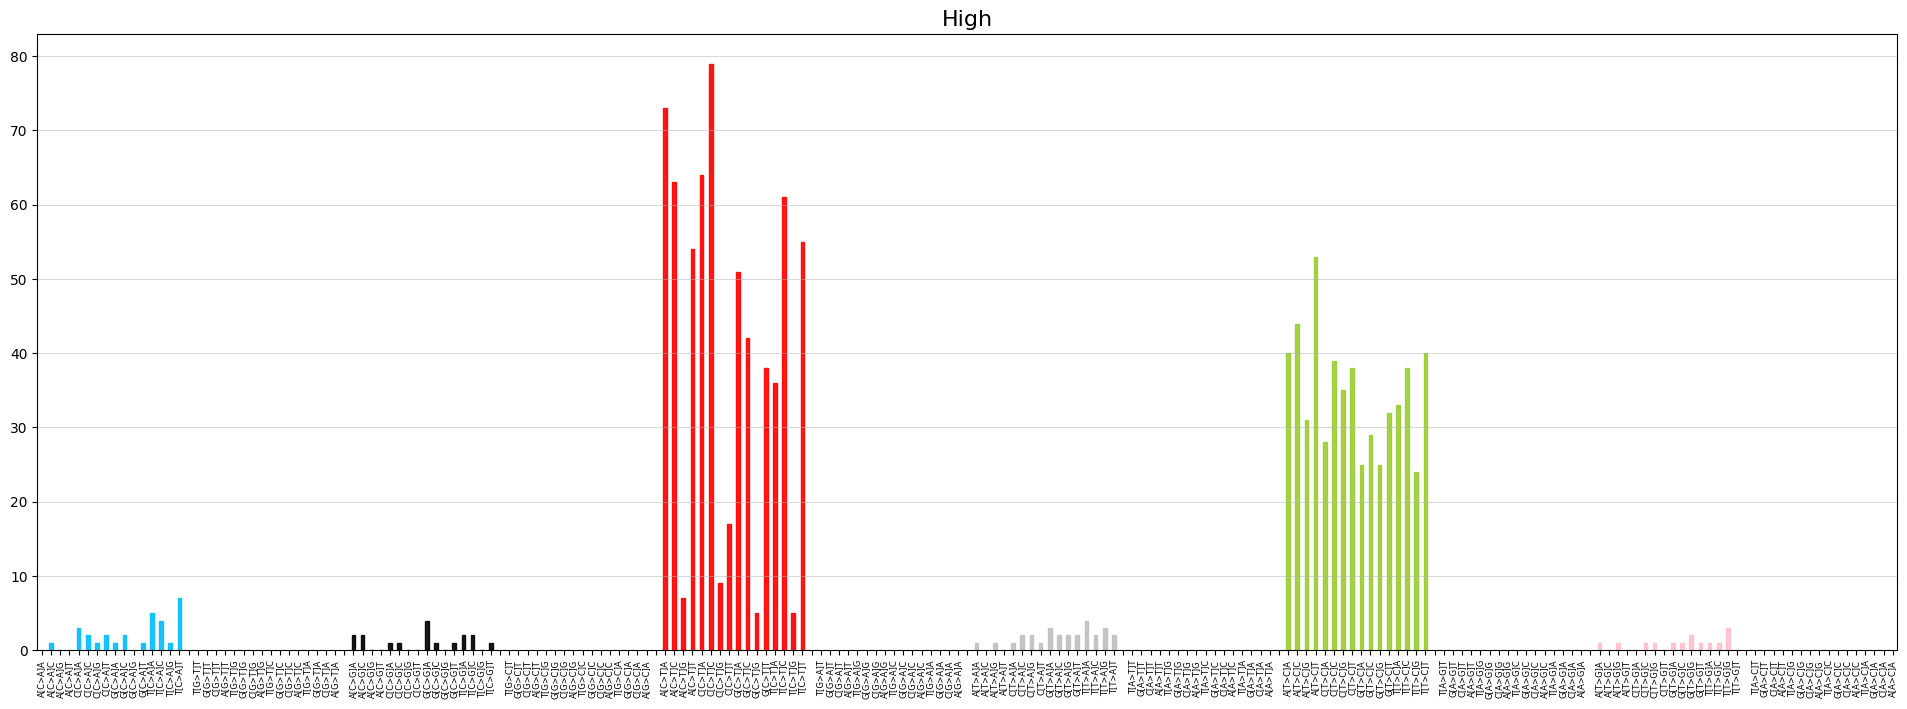

In [10]:
x = high['Mammalia__Ts & Tv'].rename('MutSpec')
x.index.name = 'Mut'
x = x.reset_index()
plot_mutspec192(x, title='High');